In [84]:
#install and download needed packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import scipy
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict,KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import Adam
warnings.filterwarnings('ignore')

In [85]:
data= pd.read_csv('TotalEnergies.csv') 

In [86]:
data.shape

(7551, 7)

In [87]:
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1994-02-28,13.8125,14.0625,13.8125,14.0000,3.785994,480800
1,1994-03-01,13.8750,13.8750,13.6875,13.7500,3.718387,231000
2,1994-03-02,13.2500,13.5000,13.1875,13.5000,3.650780,176800
3,1994-03-03,13.4375,13.4375,13.2500,13.4375,3.633877,98200
4,1994-03-04,13.3750,13.5000,13.3750,13.5000,3.650780,88400


In [88]:
data.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7546,2024-02-20,63.930000,63.930000,63.110001,63.259998,63.259998,1282700
7547,2024-02-21,63.610001,64.139999,63.389999,64.089996,64.089996,1905700
7548,2024-02-22,64.160004,64.419998,63.599998,64.139999,64.139999,1253800
7549,2024-02-23,64.199997,64.730003,63.830002,64.510002,64.510002,1004700
7550,2024-02-26,63.770000,64.320000,63.639999,64.300003,64.300003,1026900


In [89]:
data.index

RangeIndex(start=0, stop=7551, step=1)

In [90]:
data=data.drop(columns=['Adj Close'],axis=1)

In [91]:
data=data.rename(columns={'Date':'date','Open':'open','High':'high','Low':'low','Close':'close','Volume':'volume'})

In [92]:
data['date']=pd.to_datetime(data['date'])

In [93]:
data.set_index('date', inplace=True)

Text(216.97222222222223, 0.5, 'Close price')

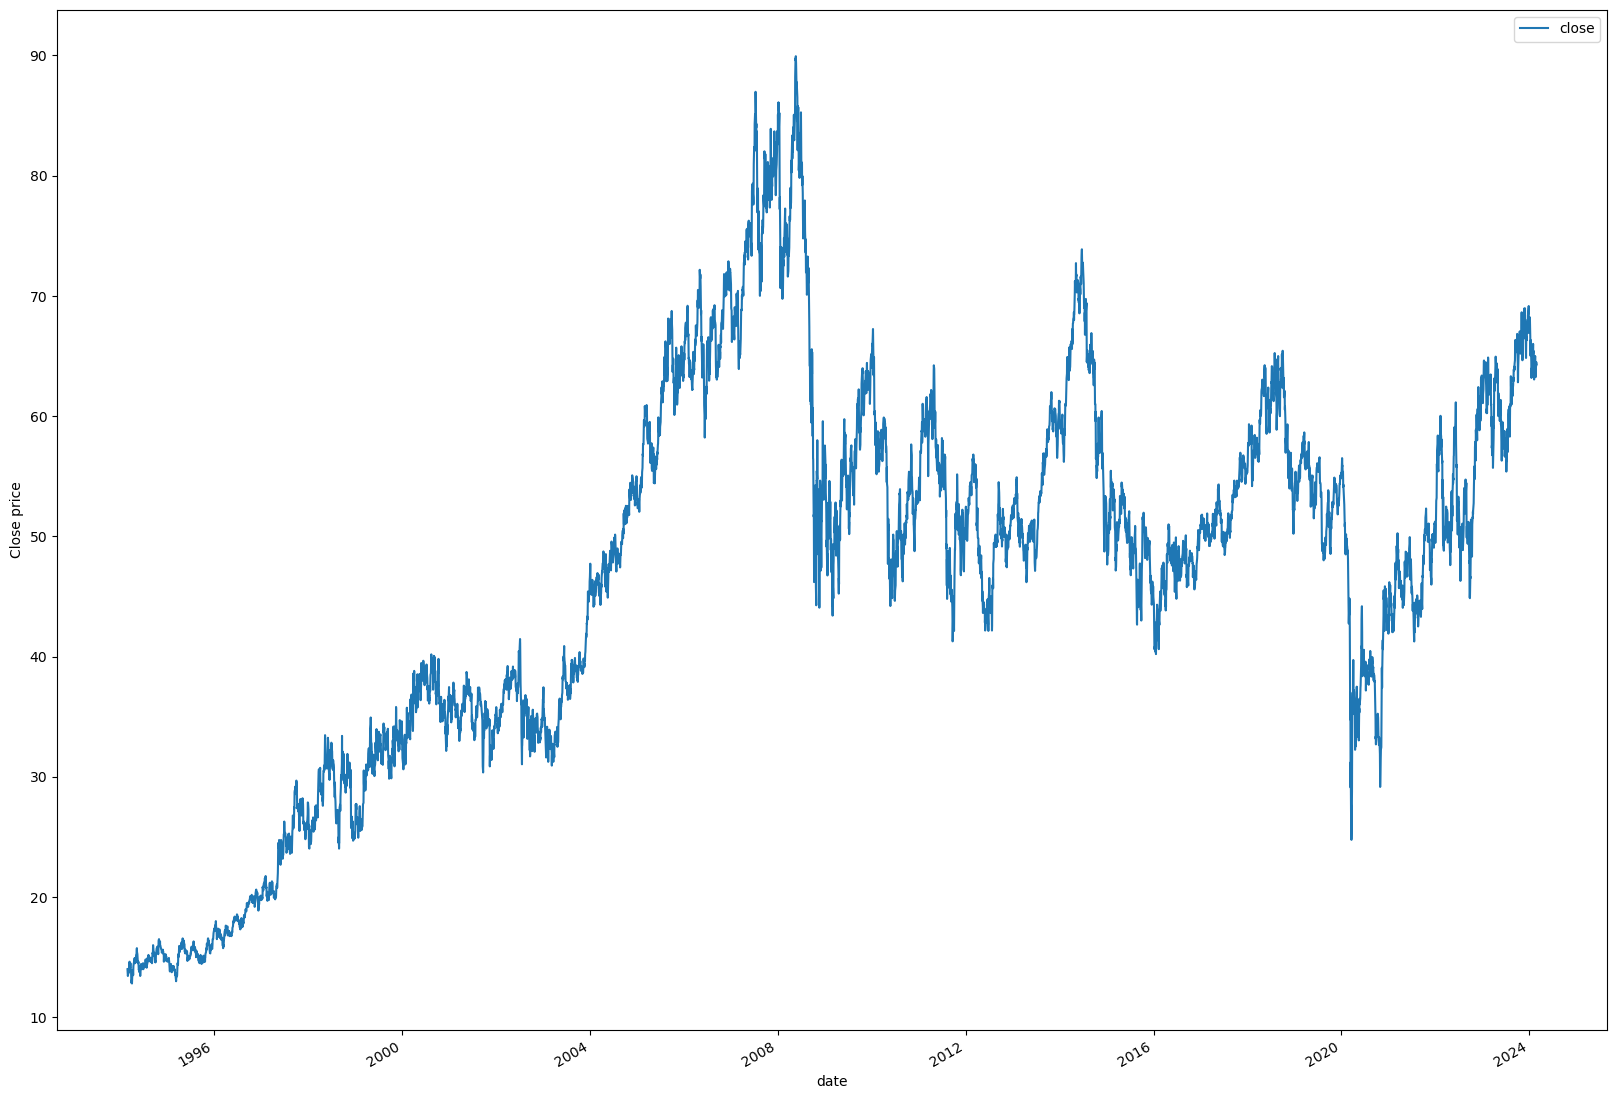

In [94]:
data.plot.line(y='close', use_index=True)
plt.savefig('real.png');
plt.ylabel('Close price')

In [95]:
data.describe()

,open,high,low,close,volume
count,7551.000000,7551.000000,7551.000000,7551.000000,7.551000e+03
mean,46.641429,47.004245,46.261206,46.646166,1.667459e+06
std,16.235481,16.335954,16.109003,16.219168,1.437190e+06
min,12.875000,12.937500,12.687500,12.812500,0.000000e+00
25%,35.000000,35.325001,34.685001,34.947501,7.316000e+05
50%,49.340000,49.730000,48.919998,49.310001,1.321000e+06
75%,57.455000,57.939999,57.045000,57.540001,2.199850e+06
max,90.779999,91.339996,89.790001,89.940002,2.705530e+07


In [96]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')

In [97]:
data['yesterday_close']=data['close'].shift(1)

In [98]:
data.head()

,open,high,low,close,volume,yesterday_close
date,,,,,,
1994-02-28,13.8125,14.0625,13.8125,14.0000,480800,NaN
1994-03-01,13.8750,13.8750,13.6875,13.7500,231000,14.0000
1994-03-02,13.2500,13.5000,13.1875,13.5000,176800,13.7500
1994-03-03,13.4375,13.4375,13.2500,13.4375,98200,13.5000
1994-03-04,13.3750,13.5000,13.3750,13.5000,88400,13.4375


### Exploratory Data Analysis

In [99]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'yesterday_close'], dtype='object')

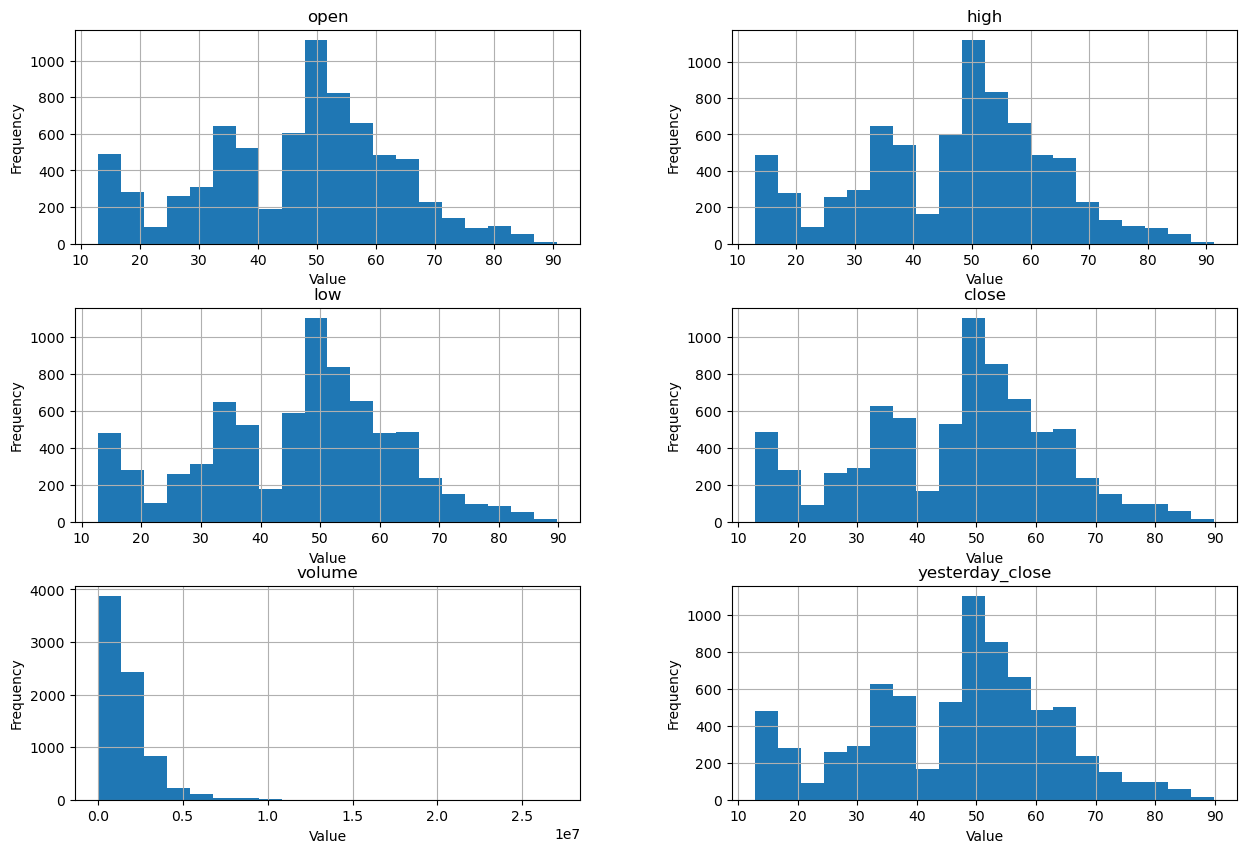

In [100]:
columns = ['open', 'high', 'low', 'close', 'volume', 'yesterday_close']

# Create histograms for the specified columns
data[columns].hist(bins=20, figsize=(15, 10))

# Add x and y labels to each histogram
for ax in plt.gcf().axes:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Save the figure
plt.savefig('charts_to1.png')

# Show the plot
plt.show()

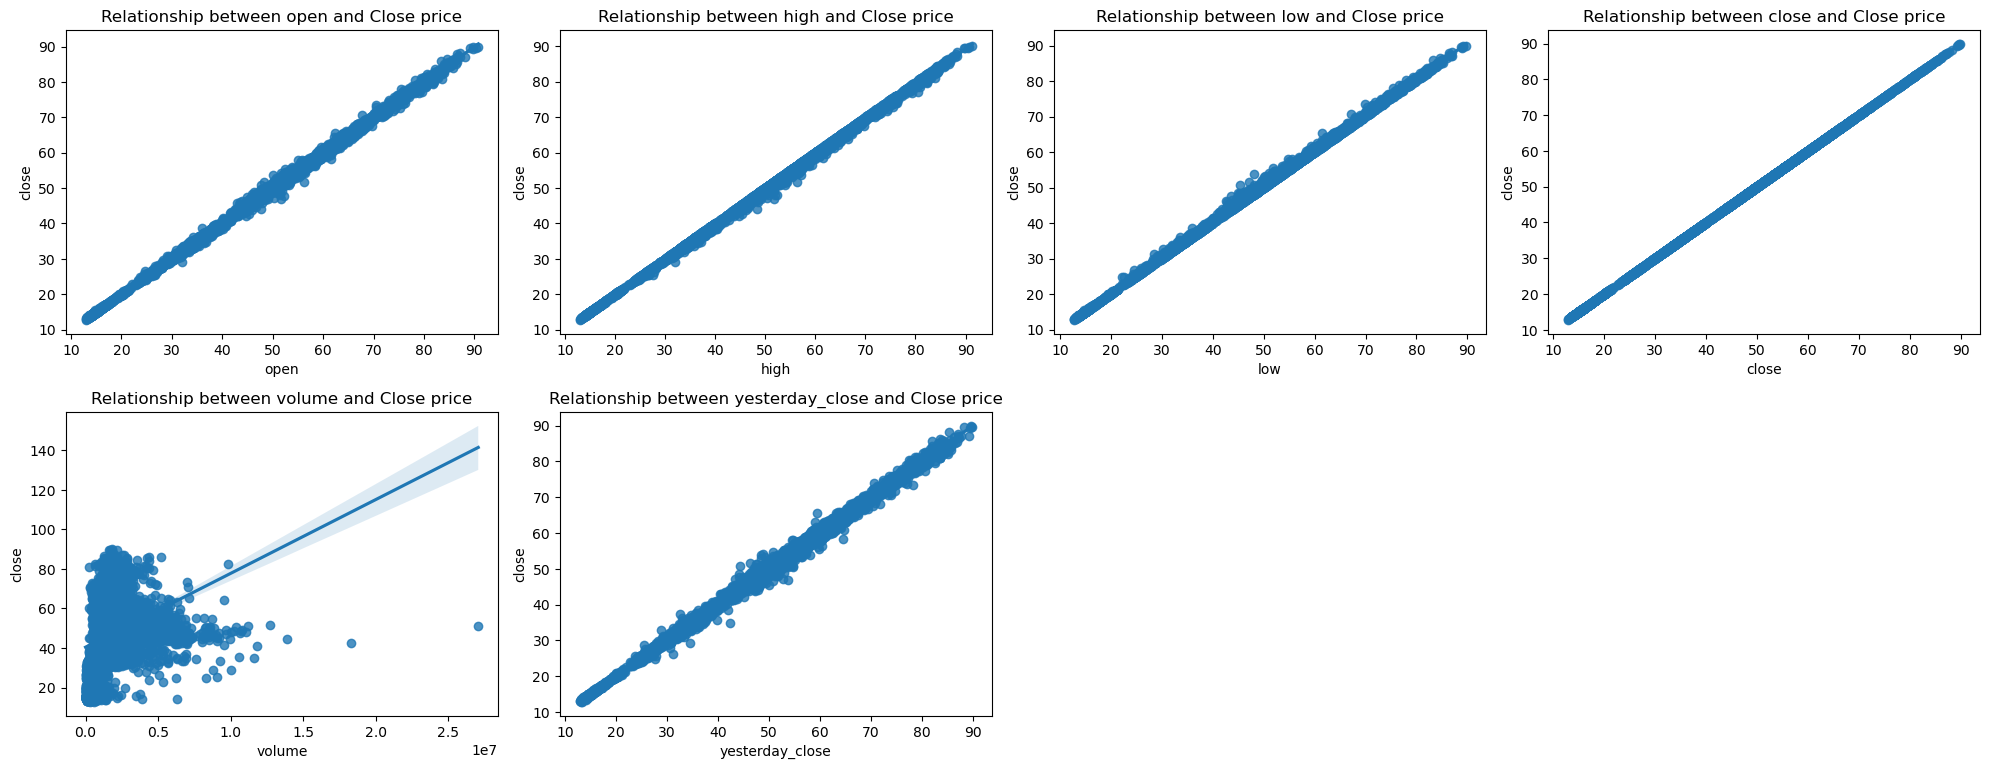

In [101]:


# Ensure the figure size is large enough to accommodate all subplots
plt.rcParams["figure.figsize"] = (20, 15)

# Define the list of categories to plot against 'CRPND'
columns= ['open', 'high', 'low', 'close', 'volume','yesterday_close']

# Create a subplot for each category
for idx, x in enumerate(columns):
    plt.subplot(4, 4, idx + 1)
    sns.regplot(data=data, x=x, y='close')
    plt.title(f'Relationship between {x} and Close price')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.savefig('bivariate1.png')
plt.show();


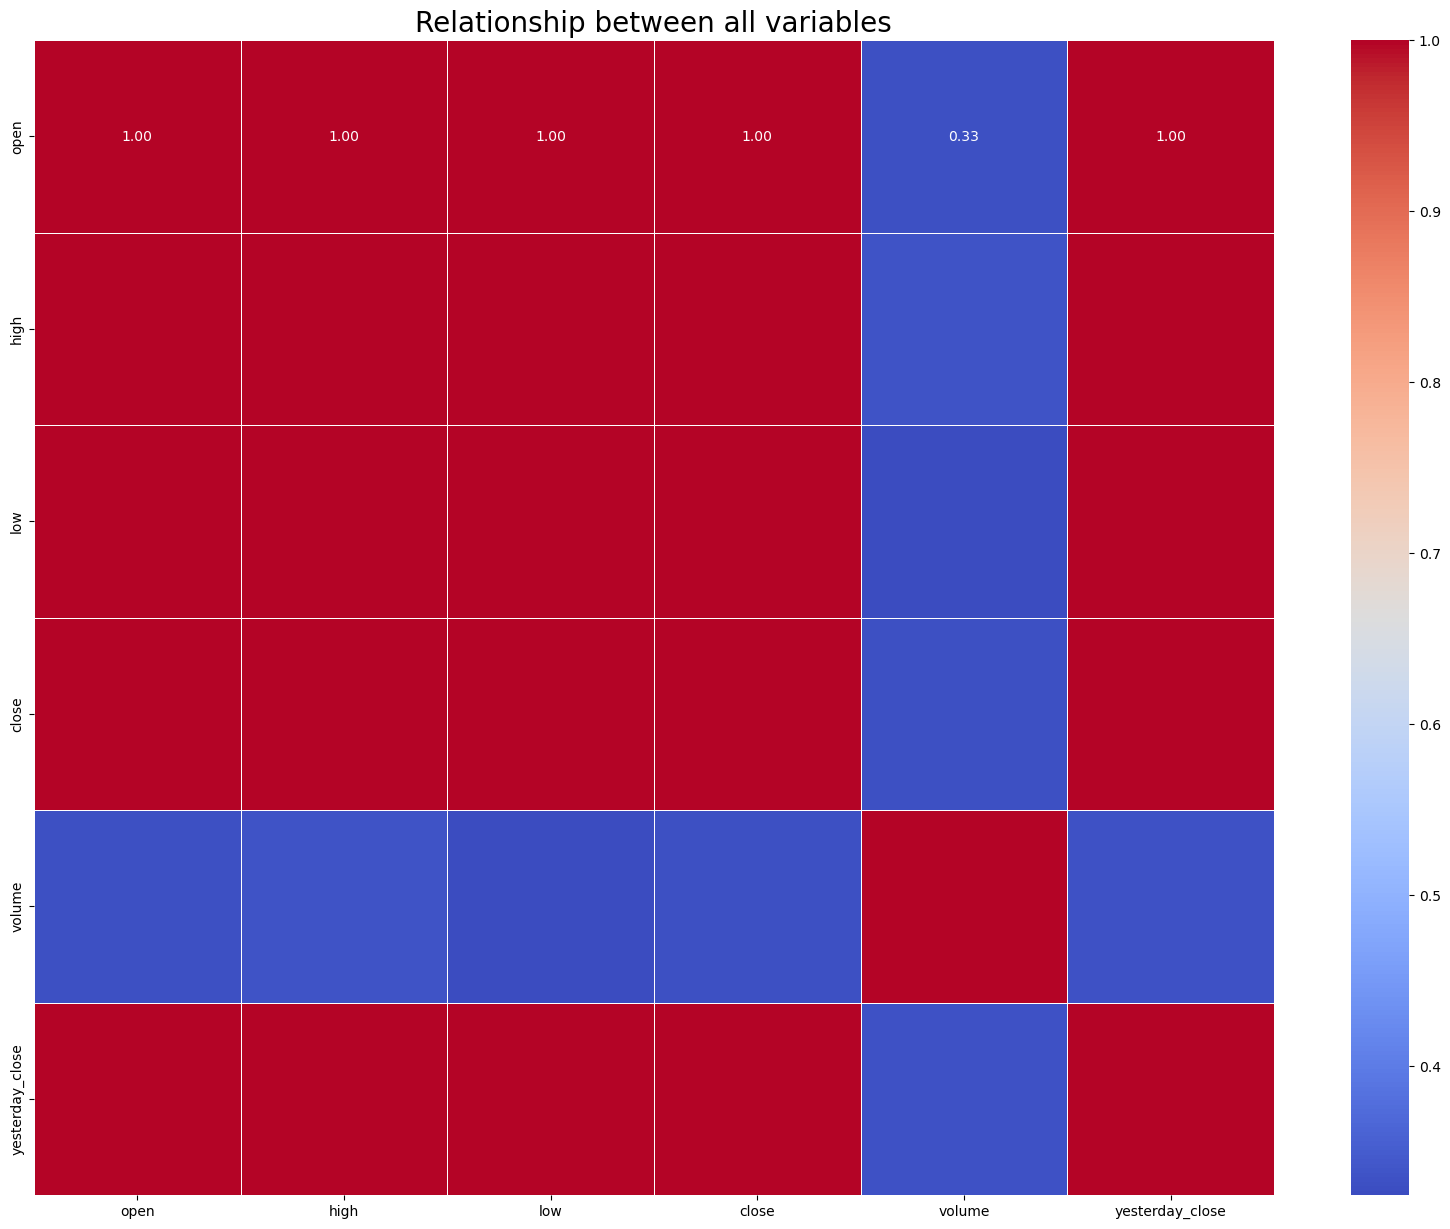

In [102]:
#plt.figure(figsize=[25, 20])
sns.heatmap(data=data.corr(), annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
# Show the plot
plt.title('Relationship between all variables', fontsize=20)
plt.savefig('image3.png')
plt.show();

### Feature Engineering and Feature Selection

In [103]:
data['mom'] = data['close'].pct_change(12) # 12 month change

In [104]:
#Create the RSI indicator
#data['rsi' + str(n)] = talib.RSI(data['close'].values, timeperiod=horizon)
def computeRSI (data, time_window):
    diff = data.diff(1).dropna()        # diff in one field(one day)

    #this preservers dimensions off diff values
    up_chg = 0 * diff
    down_chg = 0 * diff

    # up change is equal to the positive difference, otherwise equal to zero
    up_chg[diff > 0] = diff[ diff>0 ]

    # down change is equal to negative deifference, otherwise equal to zero
    down_chg[diff < 0] = diff[ diff < 0 ]


    # we set com=time_window-1 so we get decay alpha=1/time_window
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()

    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi

In [105]:
data['RSI']= computeRSI(data['close'], 14)

In [106]:
data.head()

,open,high,low,close,volume,yesterday_close,mom,RSI
date,,,,,,,,
1994-02-28,13.8125,14.0625,13.8125,14.0000,480800,NaN,NaN,NaN
1994-03-01,13.8750,13.8750,13.6875,13.7500,231000,14.0000,NaN,NaN
1994-03-02,13.2500,13.5000,13.1875,13.5000,176800,13.7500,NaN,NaN
1994-03-03,13.4375,13.4375,13.2500,13.4375,98200,13.5000,NaN,NaN
1994-03-04,13.3750,13.5000,13.3750,13.5000,88400,13.4375,NaN,NaN


In [107]:
data['SMA_3'] = data.iloc[:,3].rolling(window=8).mean()

In [108]:
data['EMA'] = data.iloc[:,3].ewm(span=40,adjust=False).mean()

In [109]:
data.head()

,open,high,low,close,volume,yesterday_close,mom,RSI,SMA_3,EMA
date,,,,,,,,,,
1994-02-28,13.8125,14.0625,13.8125,14.0000,480800,NaN,NaN,NaN,NaN,14.000000
1994-03-01,13.8750,13.8750,13.6875,13.7500,231000,14.0000,NaN,NaN,NaN,13.987805
1994-03-02,13.2500,13.5000,13.1875,13.5000,176800,13.7500,NaN,NaN,NaN,13.964010
1994-03-03,13.4375,13.4375,13.2500,13.4375,98200,13.5000,NaN,NaN,NaN,13.938326
1994-03-04,13.3750,13.5000,13.3750,13.5000,88400,13.4375,NaN,NaN,NaN,13.916944


In [110]:
data=data.dropna()

In [111]:
data.shape

(7537, 10)

In [112]:
data.columns

Index(['open', 'high', 'low', 'close', 'volume', 'yesterday_close', 'mom',
       'RSI', 'SMA_3', 'EMA'],
      dtype='object')

In [113]:
data=data.drop(columns=['open', 'high', 'low', 'yesterday_close', 'volume'],axis=1)
data.columns

Index(['close', 'mom', 'RSI', 'SMA_3', 'EMA'], dtype='object')

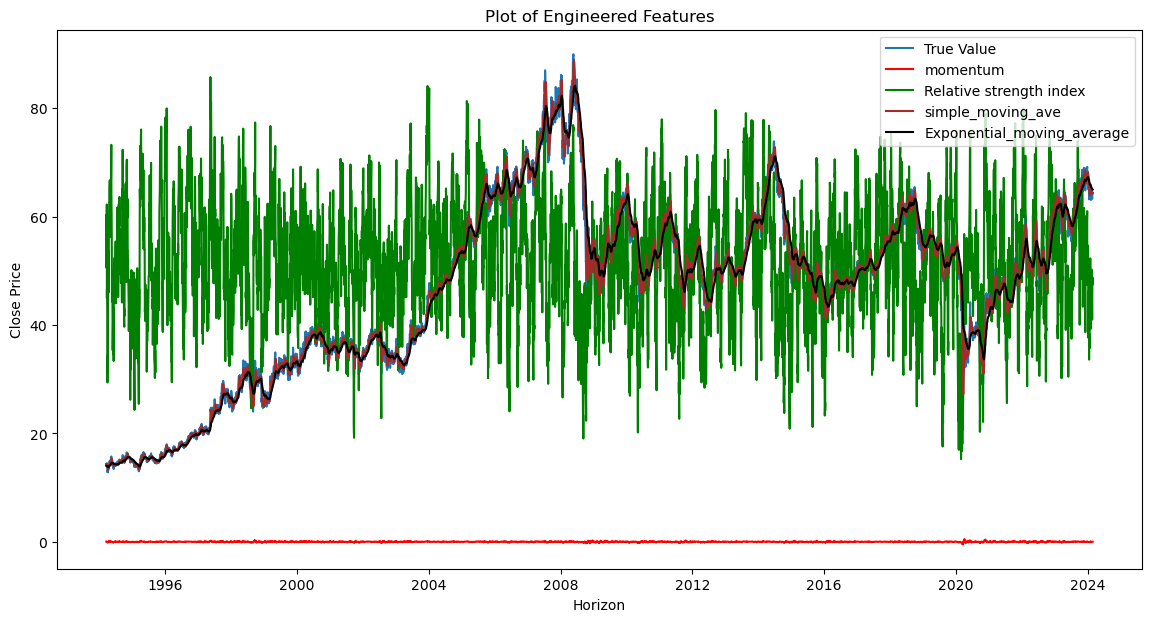

In [114]:
plt.figure(figsize=(14, 7))
plt.plot(data['close'], label='True Value')
plt.plot(data['mom'], label='momentum', color='red' )
plt.plot(data['RSI'], label='Relative strength index', color='green')
plt.plot(data['SMA_3'], label='simple_moving_ave', color='brown')
plt.plot(data['EMA'], label='Exponential_moving_average', color='black')
plt.title('Plot of Engineered Features')
plt.xlabel('Horizon')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('features.png')
plt.show();

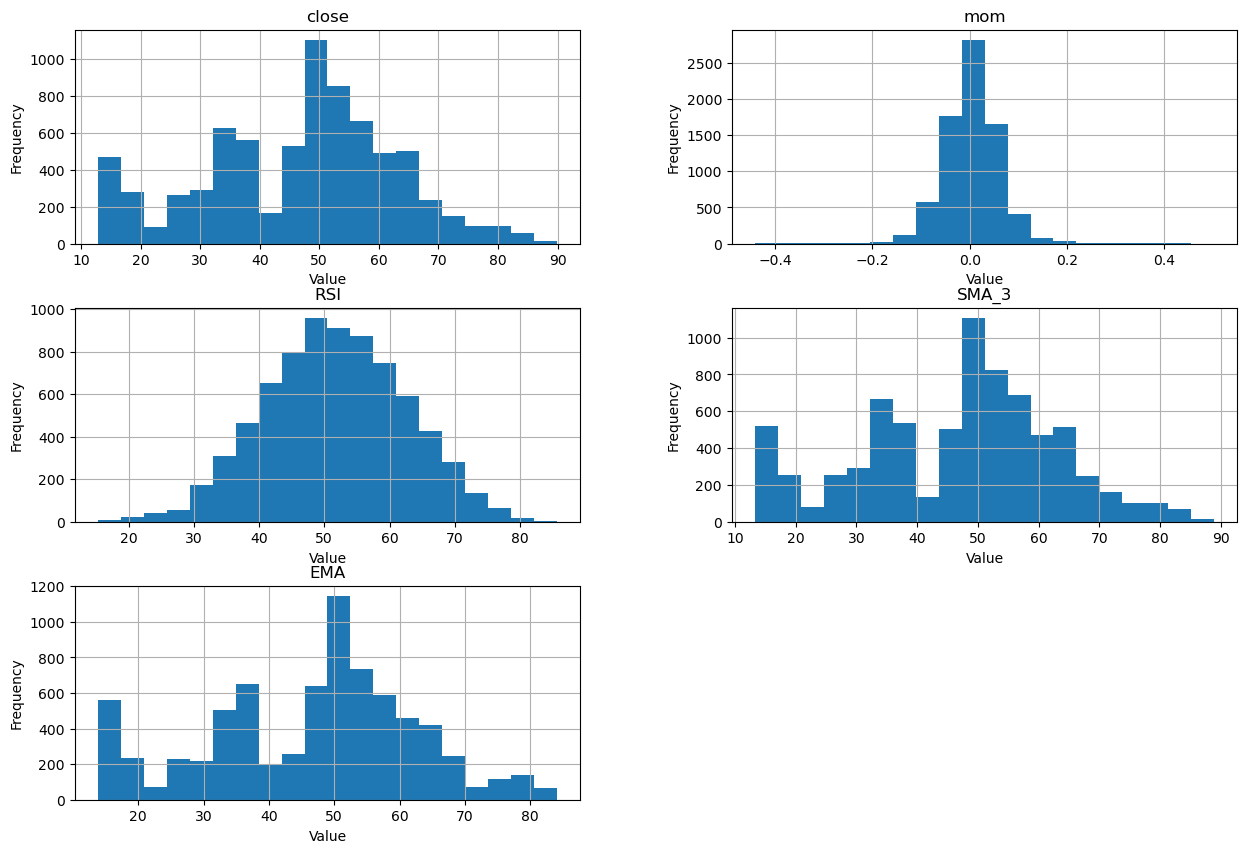

In [116]:


columns= ['close', 'mom', 'RSI', 'SMA_3', 'EMA']

# Create histograms for the specified columns
data[columns].hist(bins=20, figsize=(15, 10))

# Add x and y labels to each histogram
for ax in plt.gcf().axes:
    ax.set_xlabel('Value')
    ax.set_ylabel('Frequency')

# Save the figure
plt.savefig('charts_To2.png')

# Show the plot
plt.show()

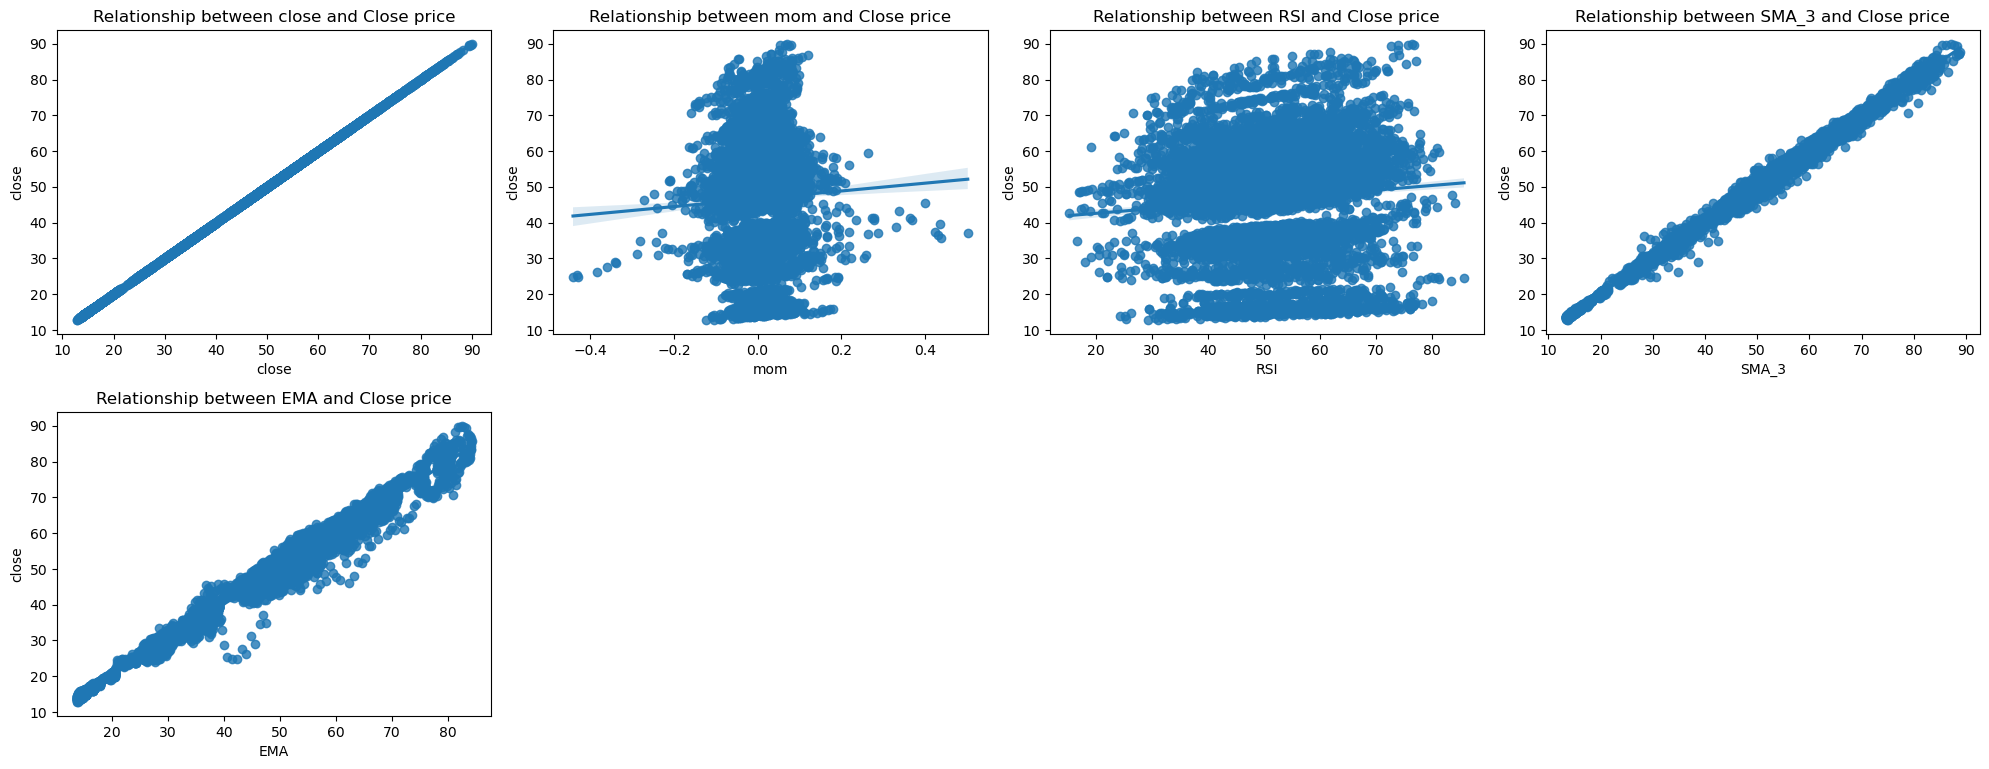

In [117]:


# Ensure the figure size is large enough to accommodate all subplots
plt.rcParams["figure.figsize"] = (20, 15)


columns= ['close', 'mom', 'RSI', 'SMA_3', 'EMA']

# Create a subplot for each category
for idx, x in enumerate(columns):
    plt.subplot(4, 4, idx + 1)
    sns.regplot(data=data, x=x, y='close')
    plt.title(f'Relationship between {x} and Close price')

# Adjust the layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.savefig('bivariate2.png')
plt.show();


In [118]:
#data= data.drop(columns=['RSI','mom'],axis=1)

In [119]:
train= data.iloc[0:6000, :]
test= data.iloc[6001 : 7537 , :]

### Train, Test Split

In [120]:
print(train.shape)
print(test.shape)

(6000, 5)
(1536, 5)


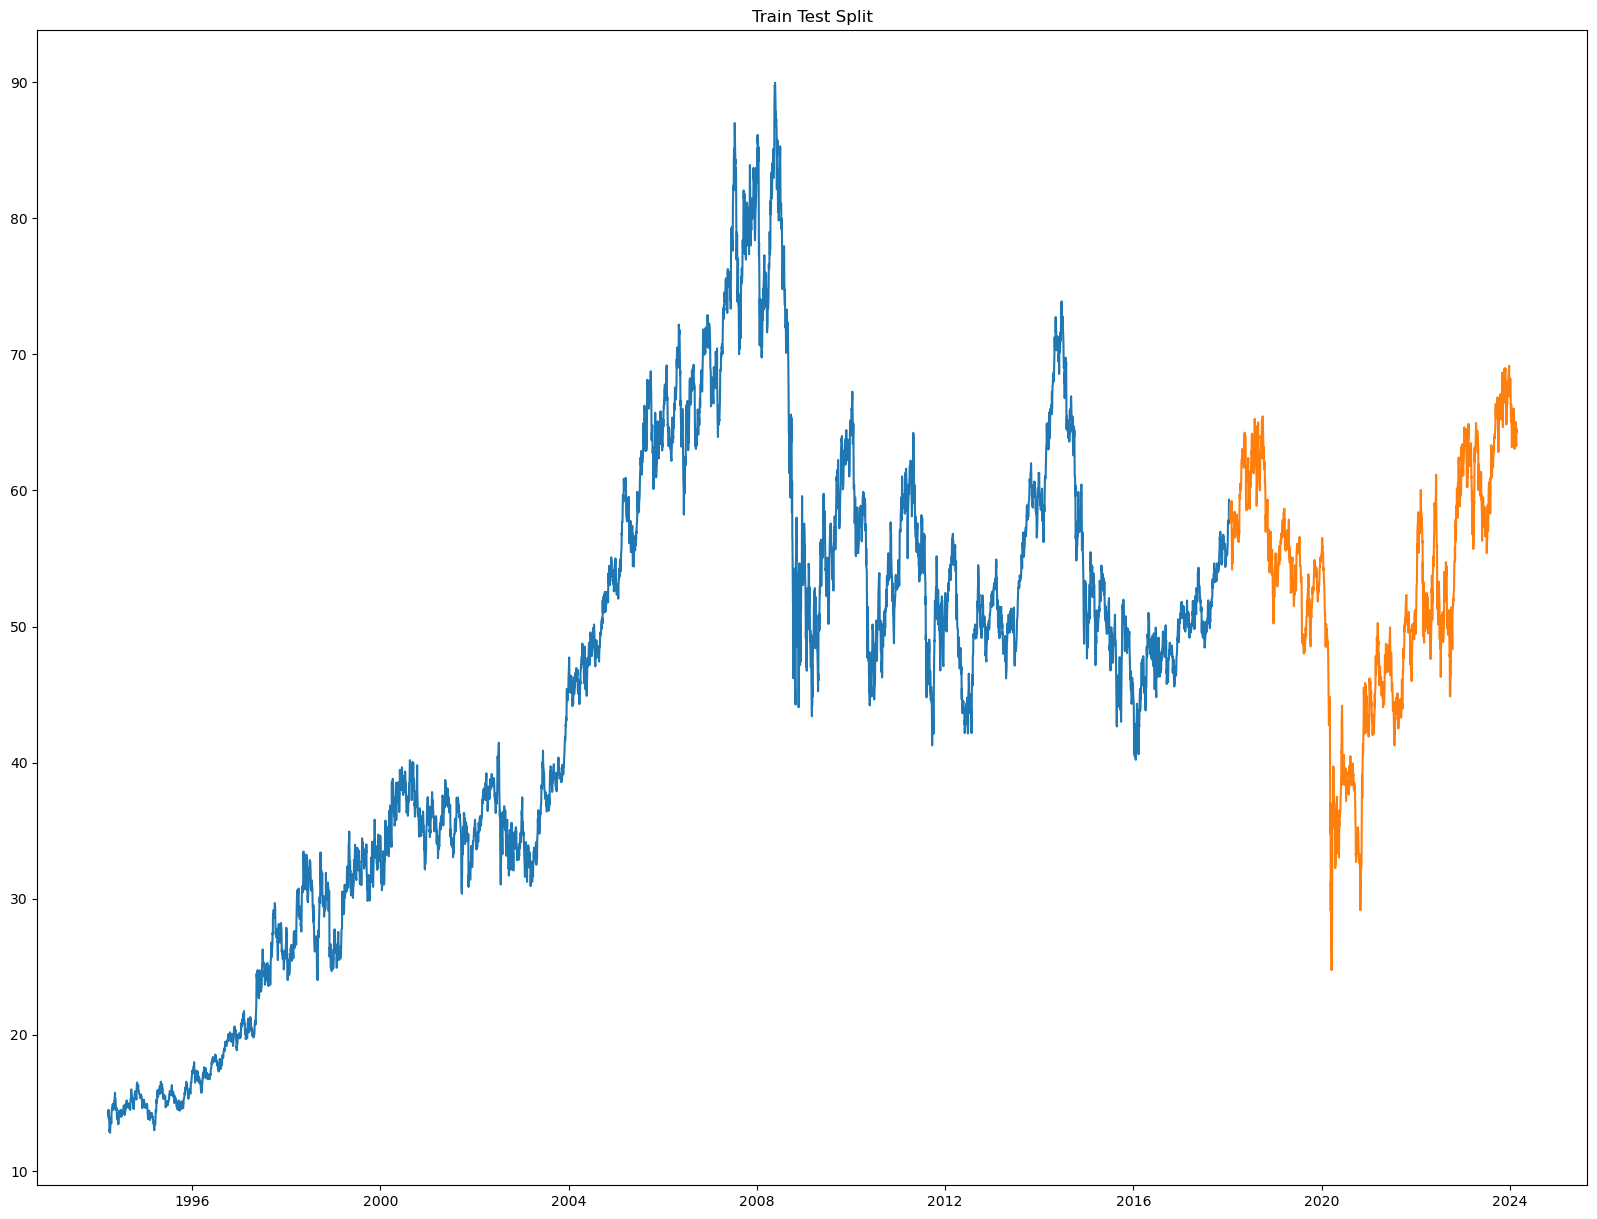

In [121]:
import matplotlib.pyplot as plt
plt.plot(train['close'], label='train')
plt.plot(test['close'], label='test')
plt.title('Train Test Split');

### Use Support Vector Machine and MLP

In [122]:
# Utility function
from sklearn.metrics import r2_score
def evaluate_model(model, x, y):
    """
    Utility function to print the model performance, (MAE and MAPE)
    model: Fitted model
    x:  features dataset
    y:  target values
    """
    predicted = model.predict(x) #get predictions
    mae = mean_absolute_error(y_true=y, y_pred=predicted)
    mse = mean_squared_error(y, predicted)
    accuracy=  r2_score(y, predicted)

    print('MAE: {:.2f}'.format(mae))
    print('MSE: {:.2f}'.format(mse))
    print('accuracy: {:.2f}'.format(accuracy))
    print()

In [123]:
x_train= train.drop(columns=['close'],axis=1)
y_train=  train['close']
x_test= test.drop(columns=['close'],axis=1)
y_test= test['close']

In [124]:
from sklearn.neural_network import MLPRegressor as MLP

In [125]:
# creating a dictionary of Regressors to be experimented on.
models_dict = {
          'SVM':SVR(), 'MLP': MLP()
}

#looping through all the regressors, fitting and evaluating them on  test data respectively
for key, model in models_dict.items():
    model.fit(x_train, y_train)
    print(f'Performance of "{key}" on Test set:')
    print('=='*28)
    print ( 'Test set:')
    print("**"*8)
    evaluate_model(model,x_test, y_test)

Performance of "SVM" on Test set:
Test set:
****************
MAE: 0.50
MSE: 0.83
accuracy: 0.99

Performance of "MLP" on Test set:
Test set:
****************
MAE: 0.52
MSE: 0.58
accuracy: 0.99



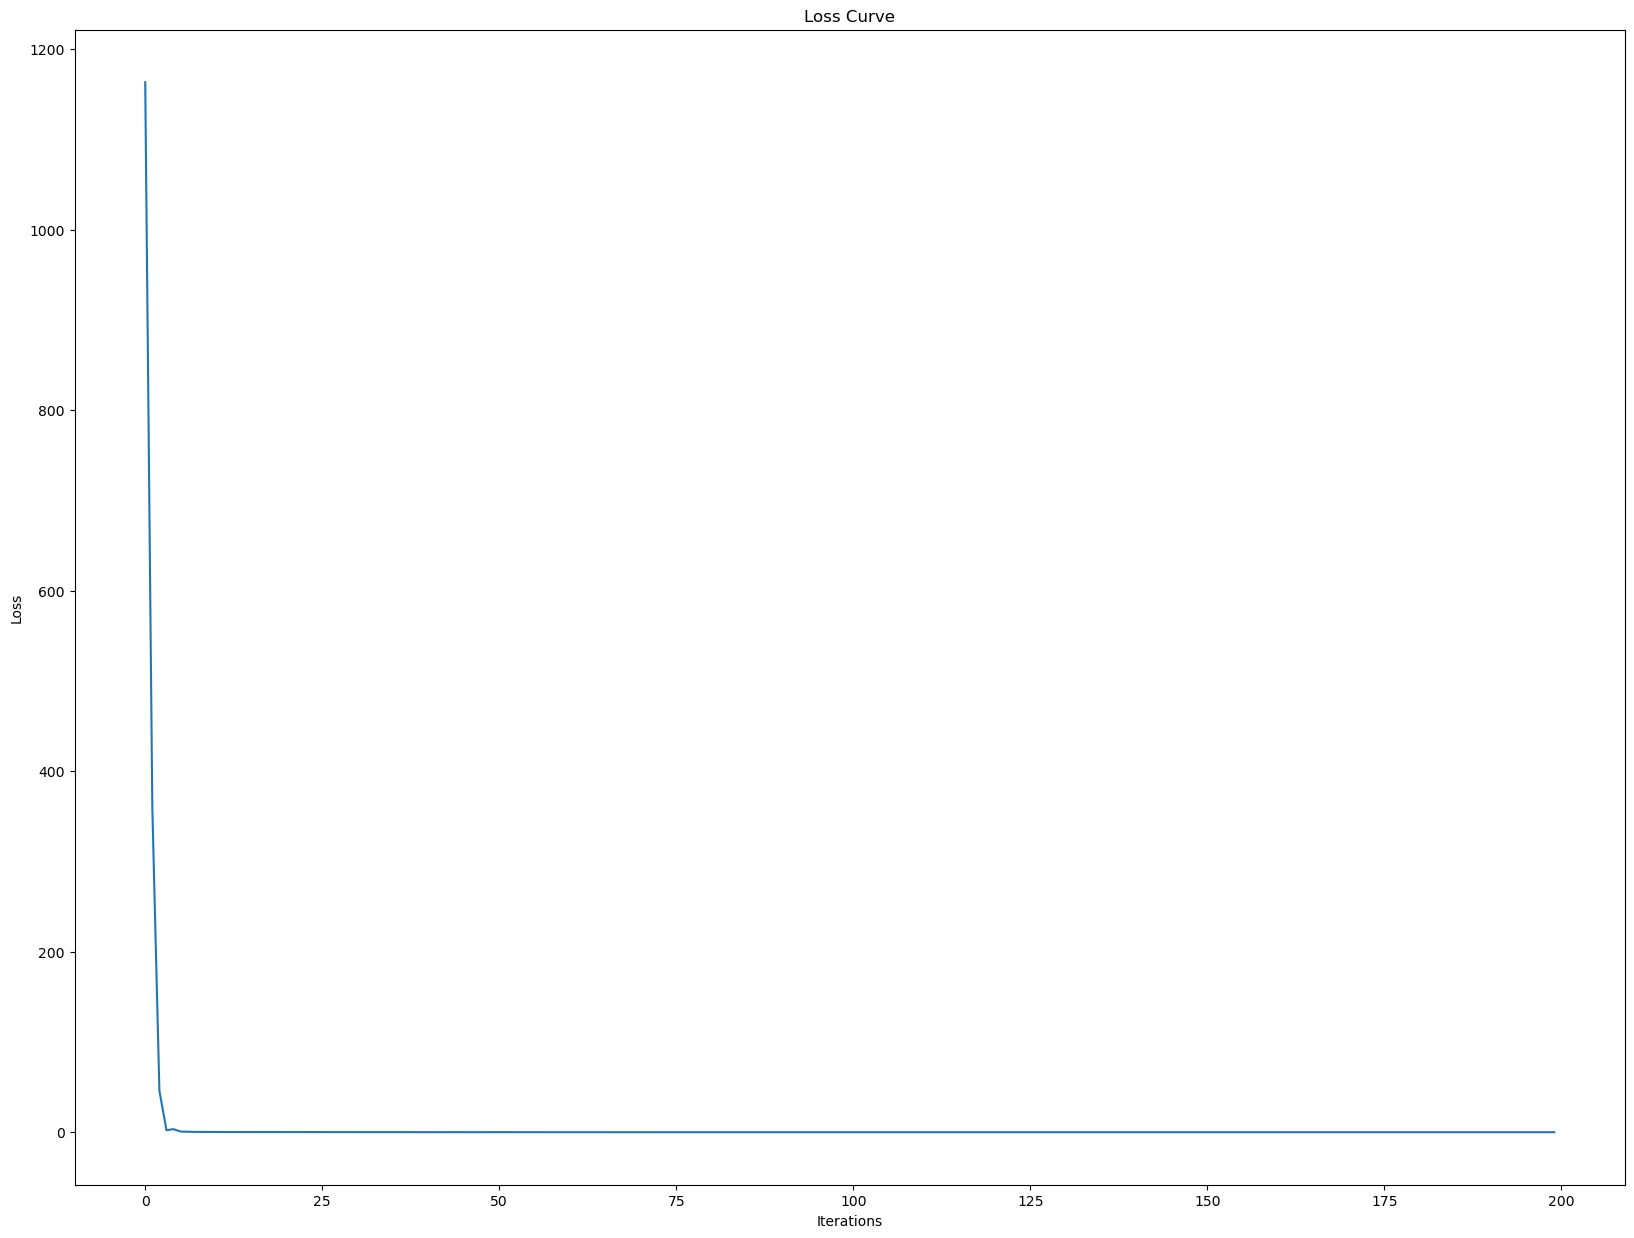

In [42]:
# Plotting the loss curve for MLP
def plot_loss_curve(model):
    """
    Function to plot the loss curve for MLP regressor
    model: Fitted MLP model
    """
    plt.plot(model.loss_curve_)
    plt.title('Loss Curve')
    plt.xlabel('Iterations')
    plt.ylabel('Loss')
    plt.show()

# Plot loss curve if the model is MLP
if 'MLP' in models_dict:
    plot_loss_curve(models_dict['MLP'])